<a href="https://colab.research.google.com/github/Re14m/isk/blob/master/2022_0224_()dogs_vs_cats_redux_kernels_edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Kaggle APIのインストール
!pip install kaggle

In [ ]:
#jsonで認証
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [ ]:
#datasetをDL
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 42.4MB/s]
 97% 262M/271M [00:01<00:00, 187MB/s]
100% 271M/271M [00:01<00:00, 171MB/s]
 97% 526M/544M [00:03<00:00, 186MB/s]
100% 544M/544M [00:03<00:00, 172MB/s]


In [ ]:
#dataフォルダを作成
!mkdir -p /content/data/ .

In [ ]:
#train.zipを解凍（trainフォルダは自動生成）
!unzip -o /content/train.zip -d /content/data/

#trainフォルダを作り、その中にdogsフォルダ,catsフォルダを作成
!mkdir -p /content/data/train/cats .
!mkdir -p /content/data/train/dogs .

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/data/train/dog.5499.jpg  
  inflating: /content/data/train/dog.55.jpg  
  inflating: /content/data/train/dog.550.jpg  
  inflating: /content/data/train/dog.5500.jpg  
  inflating: /content/data/train/dog.5501.jpg  
  inflating: /content/data/train/dog.5502.jpg  
  inflating: /content/data/train/dog.5503.jpg  
  inflating: /content/data/train/dog.5504.jpg  
  inflating: /content/data/train/dog.5505.jpg  
  inflating: /content/data/train/dog.5506.jpg  
  inflating: /content/data/train/dog.5507.jpg  
  inflating: /content/data/train/dog.5508.jpg  
  inflating: /content/data/train/dog.5509.jpg  
  inflating: /content/data/train/dog.551.jpg  
  inflating: /content/data/train/dog.5510.jpg  
  inflating: /content/data/train/dog.5511.jpg  
  inflating: /content/data/train/dog.5512.jpg  
  inflating: /content/data/train/dog.5513.jpg  
  inflating: /content/data/train/dog.5514.jpg  
  inflating: /content/data/train/dog.5515.jpg  
  inflating:

In [ ]:
#trainフォルダの画像をdogsとcatsに分ける
import os
os.chdir('/content/data/train/')

!mv dog.*.jpg dogs/
!mv cat.*.jpg cats/

In [ ]:
#test.zipを解凍（testフォルダは自動生成）
!unzip -o /content/test.zip -d /content/data/

#testフォルダを作り、その中にunknownフォルダを作成
!mkdir -p /content/data/test/unknown .

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/data/test/5499.jpg  
  inflating: /content/data/test/55.jpg  
  inflating: /content/data/test/550.jpg  
  inflating: /content/data/test/5500.jpg  
  inflating: /content/data/test/5501.jpg  
  inflating: /content/data/test/5502.jpg  
  inflating: /content/data/test/5503.jpg  
  inflating: /content/data/test/5504.jpg  
  inflating: /content/data/test/5505.jpg  
  inflating: /content/data/test/5506.jpg  
  inflating: /content/data/test/5507.jpg  
  inflating: /content/data/test/5508.jpg  
  inflating: /content/data/test/5509.jpg  
  inflating: /content/data/test/551.jpg  
  inflating: /content/data/test/5510.jpg  
  inflating: /content/data/test/5511.jpg  
  inflating: /content/data/test/5512.jpg  
  inflating: /content/data/test/5513.jpg  
  inflating: /content/data/test/5514.jpg  
  inflating: /content/data/test/5515.jpg  
  inflating: /content/data/test/5516.jpg  
  inflating: /content/data/test/5517.jpg  
  inflating: /content/data

In [ ]:
#testフォルダの画像をunknownに移動
os.chdir('/content/data/test/')

!mv *.jpg unknown/

In [ ]:
#validationフォルダを作り、その中にdogsフォルダ,catsフォルダを作成
!mkdir -p /content/data/validation/cats .
!mkdir -p /content/data/validation/dogs .

In [ ]:
#trainフォルダのcatsフォルダとdogsフォルダをvalidationにコピー
!cp -r /content/data/train/cats /content/data/validation/
!cp -r /content/data/train/dogs /content/data/validation/

In [ ]:
!ls /content/data/train/cats | wc -l
!ls /content/data/train/dogs | wc -l
!ls /content/data/validation/cats | wc -l
!ls /content/data/validation/dogs | wc -l
!ls /content/data/test/unknown | wc -l

12500
12500
12500
12500
12500


In [ ]:
#ライブラリのインポート
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import numpy as np

In [ ]:
# 乱数固定
import keras.backend as K
import tensorflow as tf

np.random.seed(seed=0)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

tf.random.set_seed(0)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
# 画像ファイルパス
train_data_dir = "/content/data/train/"
validation_data_dir = "/content/data/validation/"

In [ ]:
# モデル条件設定
img_width, img_height = 150, 150
nb_train_samples = 3000
nb_validation_samples = 1000
epochs = 50
batch_size = 32
nb_category = 2

In [ ]:
# 画像データのジェネレータ

# 訓練用
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")
# 検証用
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")

Found 25000 images belonging to 2 classes.
Found 25000 images belonging to 2 classes.


In [ ]:
# モデル定義

# モデルVGG16（not include Top）
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# モデルTop
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_category, activation='softmax'))

# vgg16とtop_modelを連結
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# layer14までの重みパメータを固定する（訓練で更新しない）
for layer in model.layers[:15]:
    layer.trainable = False

# コールバック

# early_stopping_cb = EarlyStopping(
#    monitor='val_acc', patience=10, verbose=1, mode='max')

# checkpoint_cb = ModelCheckpoint(
#    './{epoch:03d}-{val_acc:.5f}.hdf5', save_best_only=True)

csvlogger_cb = CSVLogger('./history.csv') 

# コンパイル ----------
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=5e-7, decay=5e-5),
              metrics=['accuracy'])

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# 訓練実行
history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      callbacks=[csvlogger_cb])

# モデルを保存
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
93/93 [==============================] - 38s 239ms/step - loss: 1.4047 - accuracy: 0.4755 - val_loss: 0.7866 - val_accuracy: 0.5030
Epoch 2/50
93/93 [==============================] - 22s 236ms/step - loss: 1.2524 - accuracy: 0.4903 - val_loss: 0.7268 - val_accuracy: 0.5756
Epoch 3/50
93/93 [==============================] - 22s 236ms/step - loss: 1.0953 - accuracy: 0.5474 - val_loss: 0.6779 - val_accuracy: 0.6290
Epoch 4/50
93/93 [==============================] - 22s 235ms/step - loss: 1.0204 - accuracy: 0.5796 - val_loss: 0.6730 - val_accuracy: 0.6280
Epoch 5/50
93/93 [==============================] - 23s 245ms/step - loss: 0.9241 - accuracy: 0.6108 - val_loss: 0.6479 - val_accuracy: 0.6794
Epoch 6/50
93/93 [==============================] - 22s 236ms/step - loss: 0.8761 - accuracy: 0.6310 - val_loss: 0.5832 - val_accuracy: 0.7107
Epoch 7/50
93/93 [==============================] - 22s 235ms/step - loss: 0.8373 - accuracy: 0.6368 - val_loss: 0.5709 - val_accuracy: 0.7198

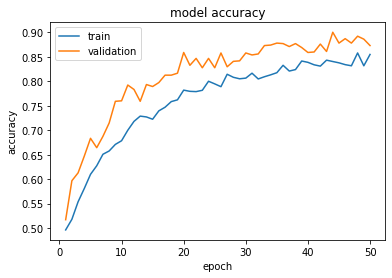

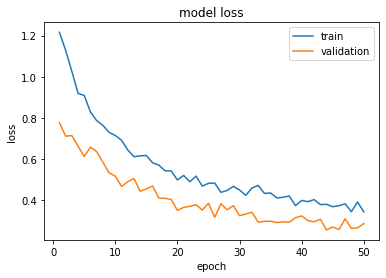

In [ ]:
# 訓練履歴をグラフで可視化
import matplotlib.pyplot as plt
import pandas as pd

history = pd.read_csv('history.csv')
history_rows = len(history)

# accuracy
plt.plot(range(1, history_rows + 1), history['accuracy']) # training
plt.plot(range(1, history_rows + 1), history['val_accuracy']) # validation
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# loss
plt.plot(range(1, history_rows + 1), history['loss'])
plt.plot(range(1, history_rows + 1), history['val_loss'])
plt.title('model accuracy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
# モデル読み込み（＠保存ファイルより再読み込み用）
from keras.models import load_model
model = load_model("./model.h5")

In [ ]:
#---評価用データで検証----

In [ ]:
#ライブラリのインポート
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import pandas as pd
import numpy as np
import os

In [ ]:
# テストデータで予測実行
test_data_dir = "/content/data/test/"
img_width, img_height = 150, 150
nb_test_samples = 30
batch_size = 1
nb_category = 2

# 画像データのジェネレータ（テスト用）
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

# 分類予測
pred = model.predict_generator(
        test_generator,
        steps=nb_test_samples,
        verbose=1)

Found 12500 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


30/30 [==============================] - 2s 17ms/step


In [ ]:
# テストデータの予測結果

labels = ['cat', 'dog']
# データ0～14 -> Cat画像
# データ15～29 -> Dog画像

print("*** test data [cat] *****")
for i in pred[0:15]:
    cls = np.argmax(i)
    score = np.max(i)
    print("pred: {}  score = {:.3f}".format(labels[cls], score))

print("-" * 30)

print("*** test data [dog] *****")
for i in pred[15:30]:
    cls = np.argmax(i)
    score = np.max(i)
    print("pred: {}  score = {:.3f}".format(labels[cls], score))

*** test data [cat] *****
pred: dog  score = 0.994
pred: cat  score = 0.977
pred: cat  score = 0.660
pred: dog  score = 0.980
pred: dog  score = 0.997
pred: cat  score = 0.944
pred: cat  score = 0.995
pred: dog  score = 0.954
pred: cat  score = 0.794
pred: cat  score = 1.000
pred: cat  score = 0.998
pred: cat  score = 0.979
pred: cat  score = 0.999
pred: cat  score = 0.999
pred: cat  score = 0.986
------------------------------
*** test data [dog] *****
pred: dog  score = 1.000
pred: dog  score = 0.980
pred: cat  score = 0.999
pred: cat  score = 0.977
pred: cat  score = 0.993
pred: dog  score = 0.967
pred: cat  score = 0.510
pred: cat  score = 1.000
pred: cat  score = 0.893
pred: cat  score = 0.956
pred: dog  score = 0.732
pred: cat  score = 0.998
pred: cat  score = 0.981
pred: dog  score = 0.948
pred: cat  score = 0.577


In [ ]:
import pandas as pd
import numpy as np
import cv2
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model

K.set_learning_phase(1) # set learning phase

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
# *************************************************
# Gradient-weighted Class Activation Mapping  *****
#**************************************************

# 呼び出し用関数
def Grad_Cam(input_model, x, layer_name):

    # 前処理
    X = np.expand_dims(x, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0

    # 予測クラス算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]

    #  勾配取得
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(class_output, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重み平均化、cam算出
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # ヒートマップ合成
    w = x.shape[0]
    h = x.shape[1]
    cam = cv2.resize(cam, (w, h), cv2.INTER_LINEAR)
    
    cam = np.maximum(cam, 0)
    if cam.max() == 0: # 色付け不可（ブルー画像になる）
      return None
    
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)
    jetcam = (np.float32(jetcam) + x / 2)

    return jetcam

In [ ]:
import os
import glob
import matplotlib.pyplot as plt

# *****************************************************
# Grad Camで色付けして可視化(テストデータで実行) ******
# *****************************************************

labels = ['cat', 'dog']
test_dir = 'data/test' # テスト画像dir
# （正解ラベルなしを仮定してunknowディレクトに保存した）

test_files = sorted(glob.glob(os.path.join(test_dir, '*', '*.jpg')))

test_data_count = len(test_files)

for idx in range(test_data_count):
  
    file = test_files[idx] # file path (試しで30データ)
    file_name = os.path.basename(file)
    img_original = load_img(file, target_size=(150,150))

    # grad cam
    arr = img_to_array(img_original)
    layer_name = 'block5_conv3' # 最後の畳み込み層
    grad_cam = Grad_Cam(model, arr, layer_name) # grad_cam呼び出し
    
    if grad_cam is None:
        layer_name = 'block5_conv2' # 最後のひとつ前の畳み込み層（ラストがダメな場合）
        grad_cam = Grad_Cam(model, arr, layer_name)   
    img_grad_cam = array_to_img(grad_cam)

    # 画像表示
    fig = plt.figure(figsize=(12, 4))

    # Image Original 
    fig.add_subplot(1, 3, 1)
    plt.imshow(img_original)
    plt.title(file_name)
    plt.axis('off')

    # Image Grad-Cam
    fig.add_subplot(1, 3, 2)
    plt.imshow(img_grad_cam)
    plt.title(layer_name)
    plt.axis('off')

    # Pie Graph prediction score
    data_pred = pred[idx]

    colors = ["orange", "green"] # pred dog

    fig.add_subplot(1, 3, 3)
    plt.pie(data_pred,
            labels=labels,
            colors=colors,
            counterclock=False,
            startangle=90,
            labeldistance=0.2,
            autopct="%.1f%%",
            pctdistance=0.7,
            textprops={'color': 'white', 'horizontalalignment':'center'})

    plt.show()